In [744]:
#import user modules
import helper_functions as hfun
import config as cf
import thouless_times as thouless
import spectral_functions as spec_fun
import sff
import adiabatics as agp
import importlib
importlib.reload(hfun)
importlib.reload(cf)
importlib.reload(thouless)
importlib.reload(spec_fun)
importlib.reload(agp)
importlib.reload(sff)

#--- importet in user module
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
import os
from utils import exit
from os import sep as kPSep
from os.path import exists

#--- other modules
import numpy as np
import itertools
import seaborn as sns
import pandas as pd
import math
import random
import imageio
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from joblib import Parallel, delayed
import copy
#plt.style.use(['science','ieee','no-latex'])

# get all the colors
import matplotlib.colors as mcolors
from scipy.special import binom
import sympy as sym
from scipy.optimize import curve_fit as fit

print(cf.base_directory)
from cmath import nan


user_settings = getattr(cf.plot_settings, 'settings')

../results/Heisenberg/disorder/PBC/


### GAP RATIO AND CHAOTIC STATISTICS

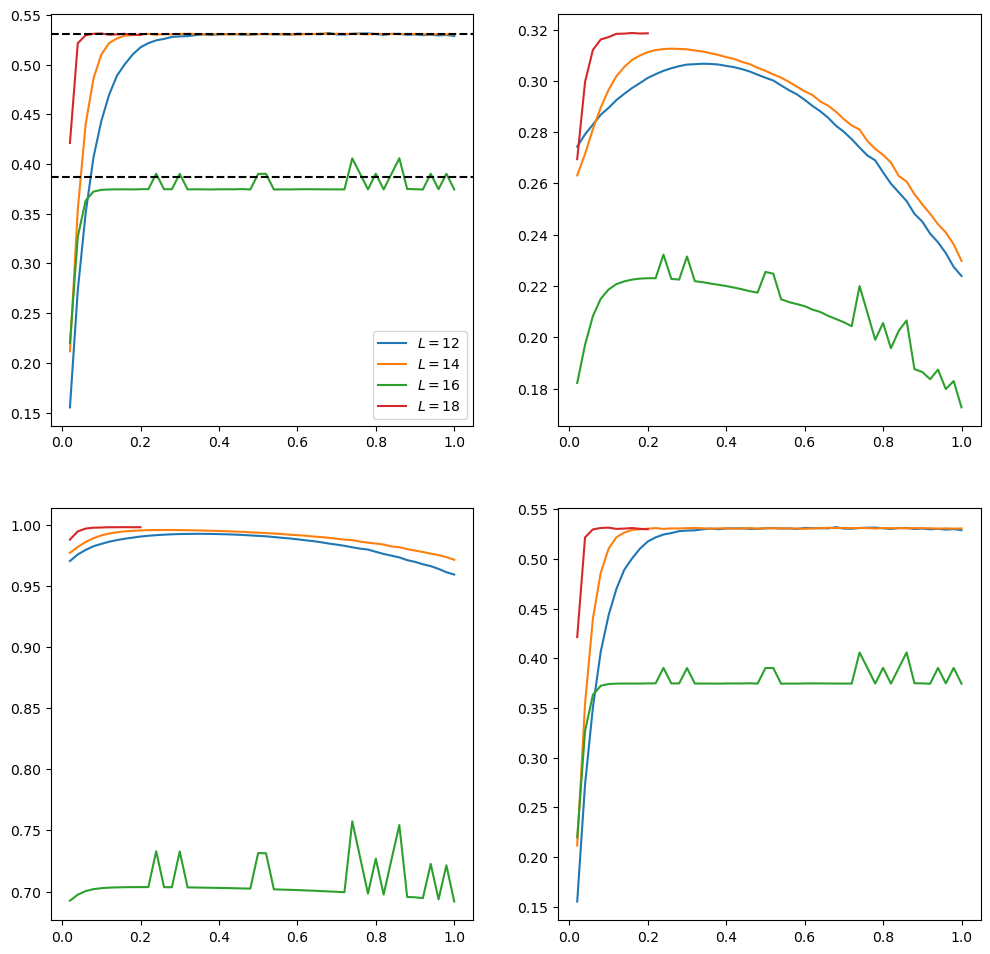

In [745]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(12,12), dpi = 100)

new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_vs(cf.plot_settings.settings['scaling'])
new_set_class.set_scaling("L")
new_set_class.set_scales(xscale='log', yscale='log')
settings = getattr(new_set_class, 'settings')

param_copy = copy.deepcopy(cf.params_arr)
vals = hfun.get_scaling_array(settings)
for x in vals:
    cf.params_arr[settings['scaling_idx']] = x
    filename = cf.base_directory + "STATISTICS" + kPSep + hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs']) + ".dat" 
    if exists(filename):
        stats = pd.read_table(filename, sep="\t", header=None)
        
        xdata = np.array(list(stats[0])[1:]).astype(float)
        gap_ratio = np.array(list(stats[1])[1:]).astype(float)
        ipr = np.array(list(stats[2])[1:]).astype(float)
        info_entropy = np.array(list(stats[3])[1:]).astype(float)
        
        ax1.plot(xdata, gap_ratio, label=hfun.key_title(x, settings))
        ax2.plot(xdata, ipr, label=hfun.key_title(x, settings))
        ax3.plot(xdata, info_entropy, label=hfun.key_title(x, settings))
        ax4.plot(xdata, gap_ratio, label=hfun.key_title(x, settings))

ax1.axhline(y=0.5307, ls='--', color='black')
ax1.axhline(y=0.3867, ls='--', color='black')
ax1.legend()
 #--- reset defaults
cf.params_arr = param_copy

### SPECTRAL FORM FACTOR

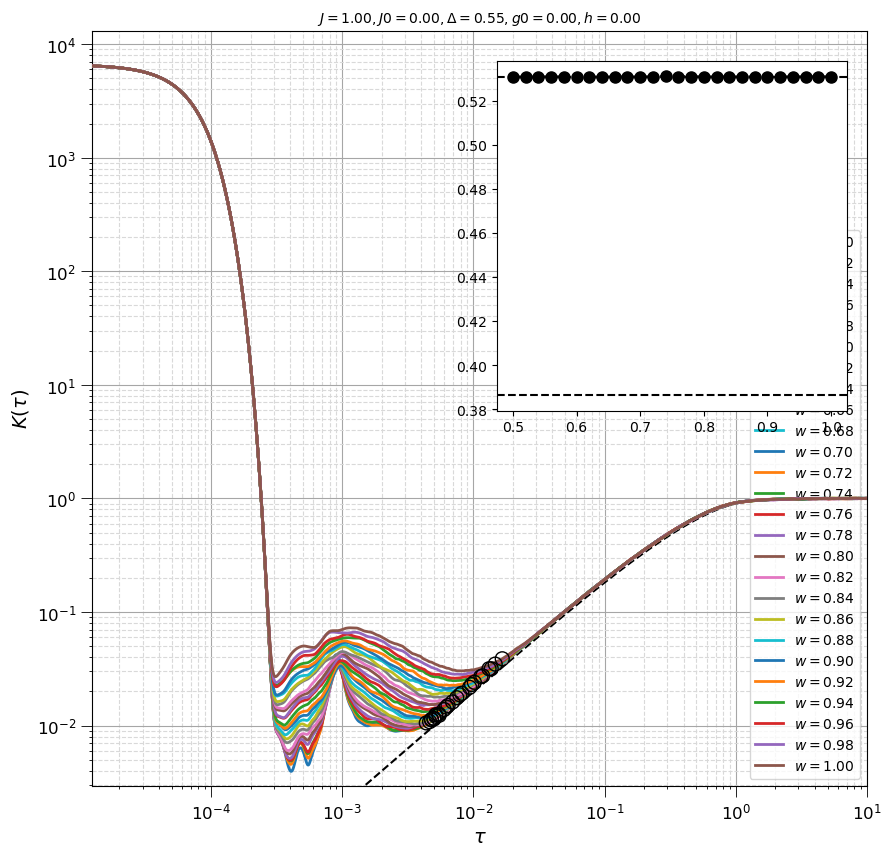

In [746]:
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(10,10), dpi = 100)
vals_sff = hfun.get_scaling_array(user_settings, 0.5, 1.0, 0.02)
  
plot_deviation = 0

if plot_deviation:
    sff.plot_deviation(axis=axis, vals=vals_sff)
else:
    axis.grid(b=True, which='major', color='0.65', linestyle='-')
    axis.grid(b=True, which='minor', color='0.85', linestyle='--')
    
    left, bottom, width, height = [0.53, 0.5, 0.35, 0.35]
    axis2 = fig.add_axes([left, bottom, width, height])
    
    sff.plot(axis=axis, vals=vals_sff, axis_inset=axis2, func_x = lambda x, a: x * 1**2)

# PLOT SPECTRAL FUNCTIONS

### PREAMBLE

In [747]:
# SET LEGEND FUNCTION

from matplotlib.lines import Line2D
def add_legend(axis):
    legend = axis.legend()
    #ax = legend.axes

    handles, labels = axis.get_legend_handles_labels()
    if user_settings['scaling'] == 'k':
        new_lab = []
        for label in labels:
            label = list(label)
            label[1] = 'q'
            new_lab.append("".join(label))
        labels = new_lab
    handles.append(Line2D([0], [0], linewidth=1, linestyle='--', marker='o', color='black'));   labels.append(r"$\omega_H$")
    handles.append(Line2D([0], [0], linewidth=1, linestyle='--', marker='o', color='black', markerfacecolor='None'));   labels.append(r"$\omega^{typ}_H$")
    #handles.append(Line2D([0], [0], linewidth=1, linestyle='--', marker='s', color='black'));   labels.append(r"$\omega_{Th}$")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
    axis.legend(handles, labels, frameon=False, loc='best', fontsize=10)




use_derivative = 0
time_dir = cf.base_directory + "timeEvolution%s"%kPSep
int_dir = cf.base_directory + "IntegratedResponseFunction%s"%kPSep
spec_dir = cf.base_directory + ("IntegratedResponseFunction%sDERIVATIVE%s"%(kPSep,kPSep) if use_derivative else "ResponseFunction%s"%kPSep)

def xover_from_below(input_array, cut):
    """Find index of value crossing threshold from below"""
    x = input_array < cut
    return x.argmax() if x.any() else -1

def xover_from_above(input_array, cut):
    """Find index of value crossing threshold from above"""
    x = input_array > cut
    return x.argmin() if x.any() else -1

def exp_fit(x, mu, a):
    """Exponential function to fit and find decay rate"""
    return a * np.exp(- x / mu)

def lin_fit(x, mu, a):
    """Linear function to fit and find decay rate from ln( f(t) )"""
    return -x / mu + a

def power_law(x, alfa, a):
    """ Power-law fit function """
    return a * x**alfa
    
def stretch_exp(x, alfa, a):
    """ Ffit function for exponential decay with arbitrary exponent """
    return a * np.exp(x*alfa)

### RELAXATION TIMES FUNCTION

In [748]:
def get_thouless_time(par, set_class = None, vals = None):
    if set_class is None:   set_class = cf.plot_settings    
    if par is None:         
        print("No parameter input!")
        raise ValueError

    " Find thouless data "
    tau_data = []
    status_time = False
    try :
        tau_data = thouless.load(getattr(set_class, 'settings'))
        status_time = True
    except OSError:
        print("No Thouless data present")
        
    taus = [];  gap_ratio = []; xvalues = []
    if status_time:    
        idx = list(tau_data[0]).index(par)
        if vals is None:    vals = tau_data[1][idx]
        for x in vals:
            idx2 = hfun.find_index(tau_data[1][idx], x)
            if idx2 >= 0:   
                taus.append(tau_data[2][idx][idx2])
                gap_ratio.append(tau_data[3][idx][idx2])
            else:           
                taus.append(nan)
                gap_ratio.append(nan)
    xvalues = vals
    return status_time, np.array(xvalues), np.array(taus), np.array(gap_ratio)

def get_relax_times(vals = None, set_class = None, operator = -1, site = -2):
    """ 
    Find relaxation times from both integrated spectral function at I(w)=1/2 and fitting autocorrelation function
    """
    if operator < 0: operator = user_settings['operator']
    if site < -1: site = user_settings['site']

    if vals is None:    vals = hfun.get_scaling_array()
    print(vals)

    if set_class is None:   set_class = cf.plot_settings    

    status_time, xvals, taus, gap_ratio = get_thouless_time(par = cf.L, set_class=set_class, vals=vals)
    relax_time = []
    
    spec_at_relax = []; relaxt_time_fit = [];   tH = [];    tH_typ = [];
    print(cf.params_arr)
    
    for i in range(0, len(vals)):
        x = vals[i]

        "Find relax time from integrated spec fun"
        status, xdata, ydata, wHnow, wHtypnow = spec_fun.load_spectral(dir=int_dir, 
                                                                        settings=user_settings, 
                                                                        parameter=x,
                                                                        spec="int",
                                                                        normalise=True,
                                                                        operator=operator,
                                                                        site=site
                                                                        )
        if status:
            idx = min(range(len(ydata)), key=lambda i: abs(ydata[i] - 0.5));
            relax_time.append(1. / xdata[idx])
            tH.append(1. / wHnow)
            tH_typ.append(1. / wHtypnow)
        else:
            relax_time.append(nan)
            tH.append(nan)
            tH_typ.append(nan)
    
        "Find relax time from autocorrelation function"
        status2, xdata2, ydata2, wHnow, wHtypnow = spec_fun.load_spectral(dir=time_dir, 
                                                                        settings=user_settings, 
                                                                        parameter=x,
                                                                        spec="time",
                                                                        normalise=True,
                                                                        operator=operator,
                                                                        site=site
                                                                        )
        
        if status2:
            cut = 30
            if x <= 0.2: cut = 120
            xfull = xdata2
            xdata2 = np.array([xdata2[i] for i in range(0,len(xdata2)) if (xdata2[i] < 5000 and xdata2[i] > cut)])
            ydata2 = np.array([ydata2[i] for i in range(0,len(ydata2)) if (xfull[i] < 5000 and xfull[i] > cut)])
            
            ydata2 = np.log10(np.abs(ydata2))
            idx_zero = np.argmin((ydata2))
            ydata2 = ydata2[:idx_zero - 15]
            xdata2 = xdata2[:idx_zero - 15]
            #print(pars)
            
            pars, sth = fit(f=lin_fit, 
                                xdata=xdata2, 
                                ydata=ydata2)
            relaxt_time_fit.append(pars[0])
        else:
            relaxt_time_fit.append(nan)

    return status_time, np.array(taus), np.array(relax_time), np.array(relaxt_time_fit), np.array(tH), np.array(tH_typ), np.array(gap_ratio)


def set_inset_style(axis, vals, set_class, ylim = None, ylabel = None):
    """ 
    Sets style of plot with relaxation times
    """
    if ylim is None:    ylim = (1e-1, 7e3)
    if ylabel is None:  ylabel = "\\tau_{rel}"
    
    ii = user_settings['scaling_idx']
    xlab = "q/\\pi" if ii == 5 else (hfun.var_name if ii == 2 else user_settings['scaling'])

    hfun.set_plot_elements(axis = axis, xlim = (0.95*min(vals), 1.05*max(vals)), 
                                        ylim = ylim, ylabel = ylabel, xlabel = xlab, 
                                        settings=getattr(set_class, 'settings'), font_size=10, set_legend=True)
    
    axis.set_yscale('log')
    axis.set_xscale('log')
    axis.tick_params(axis='both', which='both',length=2)

    axis.grid(b=True, which='major', color='0.75', linestyle='-')
    axis.grid(b=True, which='minor', color='0.85', linestyle='--')
    add_legend(axis)
    axis.legend(ncol=3, loc='lower center')

def set_inset(axis, set_class, vals, taus, relax_time, relaxt_time_fit, tH, tH_typ, status_time = True):
    """ 
    Plots relaxation times
    """
    ii = user_settings['scaling_idx']
    xlab = "q/\\pi" if ii == 5 else (hfun.var_name if ii == 2 else user_settings['scaling'])
    if set_class is None:
        set_class = cf.plot_settings

    axis.plot(vals, relax_time, marker='o', label='int-fit')
    axis.plot(vals, relaxt_time_fit, marker='o', label='exp fit')
    axis.plot(vals, tH, linestyle='--', label=r"$t_H$", color='gray')
    #axis.plot(vals, tH_typ, linestyle=':', label=r"$t_H^{typ}$", color='gray')

    axis.plot(vals, 2e0 / vals**2, linestyle='--', color='red', label=r"$%s^{-2}$"%xlab)
    axis.plot(vals, 1e0 / vals**1., linestyle='--', color='black', label=r"$%s^{-1}$"%xlab)

    if status_time and user_settings['scaling_idx'] == 5: 
        axis.axhline(y=taus[0], ls='--', color='black')
        axis.annotate("$\it{Thouless}\ \it{Time}$", xy=(0.3,1.5e3), color='black', size=12)
    else: 
        if status_time == False or cf.model == 2: print('No data')
        else: axis.plot(vals, taus, linestyle='--', color='black', marker='o', label=r"$\tau_{Th}$")

    set_inset_style(axis, vals, set_class)

#axis2.xaxis.set_minor_locator(plt.MultipleLocator(0.2))
#def format_func(value, tick_number):
#    return "%.1f"%value
#def format_func2(value, tick_number):
#    return "%d"%value
#axis2.xaxis.set_minor_formatter(plt.FuncFormatter(format_func))
#axis2.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
#axis2.yaxis.set_major_formatter(plt.FuncFormatter(format_func2))



## MAIN SPECTRALS

[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[12 14 16 18]


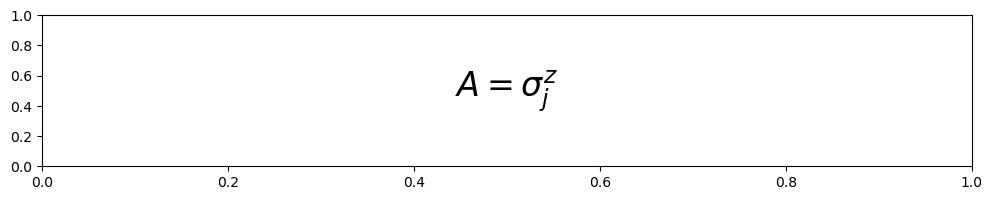

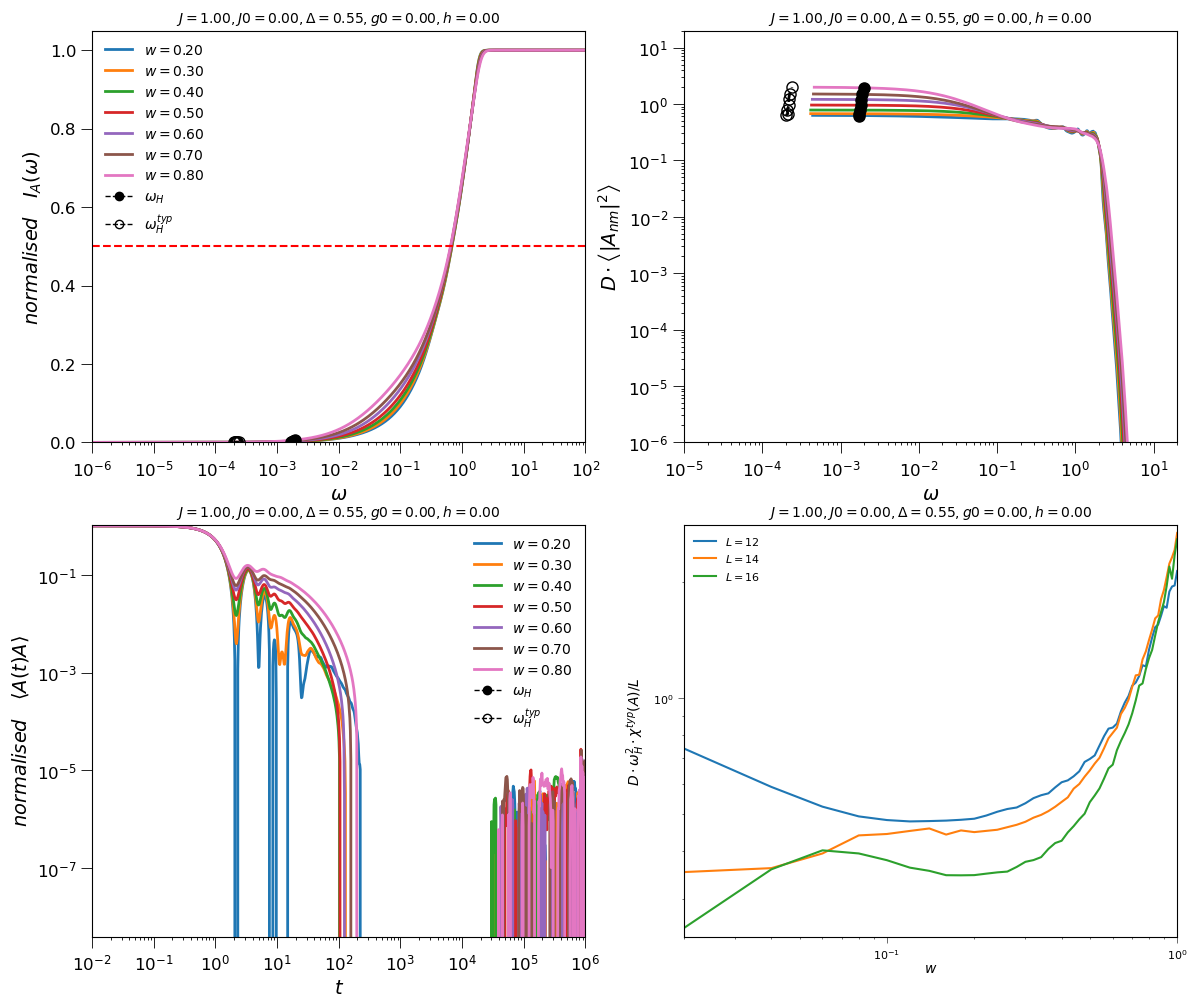

In [749]:

x0 = 0.2
xend = 0.8
dx = 0.1
vals = hfun.get_scaling_array(user_settings, x0, xend, dx)
print(vals)
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(12,2), dpi = 100)
axis.annotate(r"$A=$"+cf.operator_formuals[user_settings['operator']], xy=(0.5, 0.5), color='black', size=24, ha='center', va='center')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(14,12), dpi = 100)
func_t = lambda y, x: y #* x**2
func_w = lambda y, x: y #/ x**2

#---------------------- TIME EVOLUTION
spec_fun.plot_spectral(axis = ax3, settings=user_settings, vals = vals,
                        xlab="t", ylab="\\langle A(t)A\\rangle", 
                        xscale='log',yscale='log', normalise=True, 
                        spec="time", func_x=func_t)
add_legend(axis=ax3)
#ax3.set_ylim(-0.1,1)
#ax3.set_xlim(0,2e2)
#---------------------- INTEGRATED SPECTRAL FUNCTION
spec_fun.plot_spectral(axis = ax1, settings=user_settings, vals = vals,
                        xlab="\\omega", ylab="I_A(\\omega)", 
                        yscale='linear', normalise=True, 
                        spec="int", func_x=func_w)
add_legend(axis=ax1)
ax1.axhline(y=0.5, ls='--', color='red')
#ax1.legend(title=r"$A=H_{q=1}$")
ax1.set_ylim(0,1.05)

#---------------------- SPECTRAL FUNCTION
spec_fun.plot_spectral(axis = ax2, settings=user_settings, vals = vals,
                        xlab="\\omega", ylab="D\\cdot\\left\\langle|A_{nm}|^2\\right\\rangle", 
                        xscale='log', yscale='log', func_x=func_w, 
                        spec="spec", use_derivative=use_derivative)
if use_derivative: ax2.set_ylim(5e-30, 1e3)
else: ax2.set_ylim(1e-6, 2e1)
ax2.set_xlim(1e-5, 2e1)
#add_legend(axis=ax2)
xval=np.logspace(-6,1,100)
#ax2.plot(xval, 0.38+2*xval, linestyle='--', color='black')
#ax2.plot(xval, 3e0/xval, linestyle='--', color='black')
#ax2.plot(xval, 3e0/xval**2, linestyle='--', color='red')



#---------------------- ADIABATICS
new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_vs(cf.plot_settings.settings['scaling'])
new_set_class.set_scaling("L")
new_set_class._settings['site'] = -1
new_set_class.set_scales(xscale='log', yscale='log')
agp.plot_agp(axis = ax4, settings_class=new_set_class, which=2, operator=user_settings['operator'], site=-1)
#ax4.set_ylim(1e-2, 1e1)


## SPECTRAL FUNCTION WITH RELAXATION TIME

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02]
[12 14 16 18]
[16, 1.0, 0.55, 0.0, 0.7, 0, 1, 1, 0.0, 0.0]


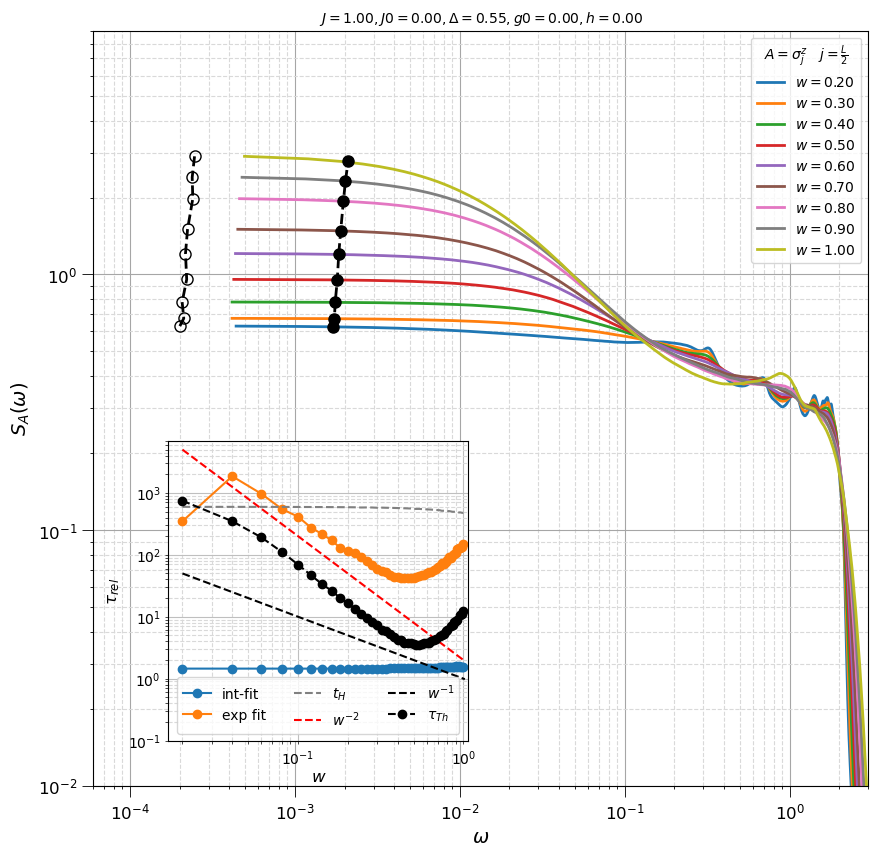

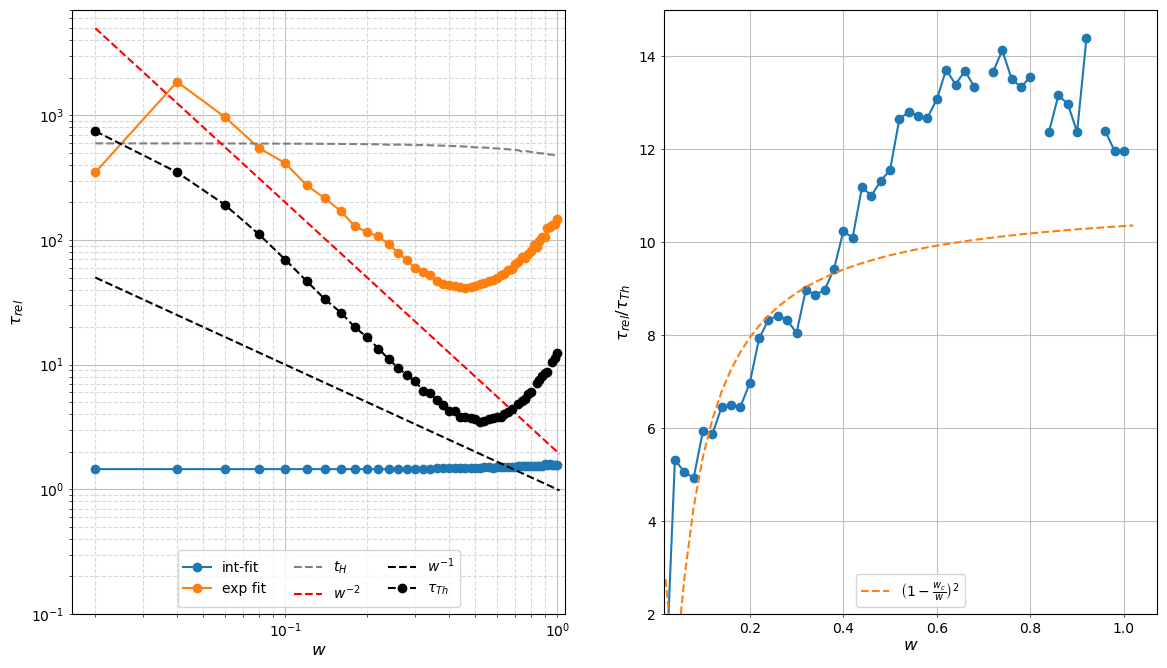

In [750]:
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(10,10), dpi = 100)

func = lambda y, x: y #* x**1.33

vals_spec = hfun.get_scaling_array(user_settings, 0.2, 1.02, 0.1)

spec_fun.plot_spectral(axis = axis, settings=user_settings, vals = vals_spec, 
                        xlab="\\omega", ylab="S_A(\\omega)", yscale='log', xscale='log', 
                        normalise=False, spec="spec", func_x=func, 
                        use_derivative=use_derivative)
add_legend(axis=axis)
addition = r"$\quad j=\frac{L}{2}$" if user_settings['operator'] < 8 else ""
try:
    idx = (cf.operator_formuals[user_settings['operator']][2:]).index("=")
    leg = axis.legend(title=r"$A=$"+cf.operator_formuals[user_settings['operator']][0:idx] + "$" + addition, loc='upper right')
except ValueError:
    leg = axis.legend(title=r"$A=$"+cf.operator_formuals[user_settings['operator']] + addition, loc='upper right')

axis.grid(b=True, which='major', color='0.65', linestyle='-')
axis.grid(b=True, which='minor', color='0.85', linestyle='--')
axis.set_ylim(1e-2, 9e0)
axis.set_xlim(6e-5, 3e0)
#leg = axis.legend(title=r"$A=J^s_{cur}$", fontsize=18, loc='lower right')
#leg.get_title().set_fontsize('18')
#axis.title.set_text("")


new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_vs(user_settings['scaling'])
new_set_class.set_scaling('L')

ii = user_settings['scaling_idx']
xlab = "q/\\pi" if ii == 5 else (hfun.var_name if ii == 2 else user_settings['scaling'])

left, bottom, width, height = [0.2, 0.17, 0.3, 0.3]
axis2 = fig.add_axes([left, bottom, width, height])
vals = hfun.get_scaling_array(settings=user_settings, 
                                    x0=0.00, 
                                    xend=1.02, 
                                    dx=0.02)

status_time, taus, relax_time, relaxt_time_fit, tH, tH_typ, gap_ratio = get_relax_times(vals=vals, set_class=new_set_class)

trueQ = 2 * vals / cf.L if user_settings['scaling_idx'] == 5 else vals    
set_inset(axis2, new_set_class, trueQ, taus, relax_time, relaxt_time_fit, tH, tH_typ, status_time)


fig, (ax1, ax2) = plt.subplots( nrows=1, ncols=2, figsize=(14,8), dpi = 100)
set_inset(ax1, new_set_class, vals, taus, relax_time, relaxt_time_fit, tH, tH_typ, status_time)
ax2.plot(trueQ, relaxt_time_fit / taus, marker='o')
ax2.plot(trueQ, 11. * (1.0 - 0.03 / trueQ)**2, linestyle='--', label=r"$\left( 1 - \frac{%s_c}{%s}\right)^2$"%(xlab, xlab))
set_inset_style(axis = ax2, 
                vals = vals, 
                set_class = new_set_class,
                ylim = (2, 15),
                ylabel = "\\tau_{rel}/\\tau_{Th}")
ax2.set_xscale('linear')
ax2.set_yscale('linear')

$$\tau_{Th}\sim \left(\Delta-\Delta_c\right)^{-2}$$

$$\tau_{rel}^{\sigma^z_j={L/2}}\sim \Delta^{-2}$$

$$ \frac{\tau_{rel}^{\sigma^z_j={L/2}}}{\tau_{Th}}\sim\left(1-\frac{\Delta_c}{\Delta}\right)^2$$

$$\langle H \sigma^z_{j=L/2}\rangle=?$$

[12 14 16 18]
[0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28 0.3  0.32 0.34 0.36
 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56 0.58 0.6  0.62 0.64
 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84 0.86 0.88 0.9  0.92
 0.94 0.96 0.98 1.  ]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


ZeroDivisionError: float division by zero

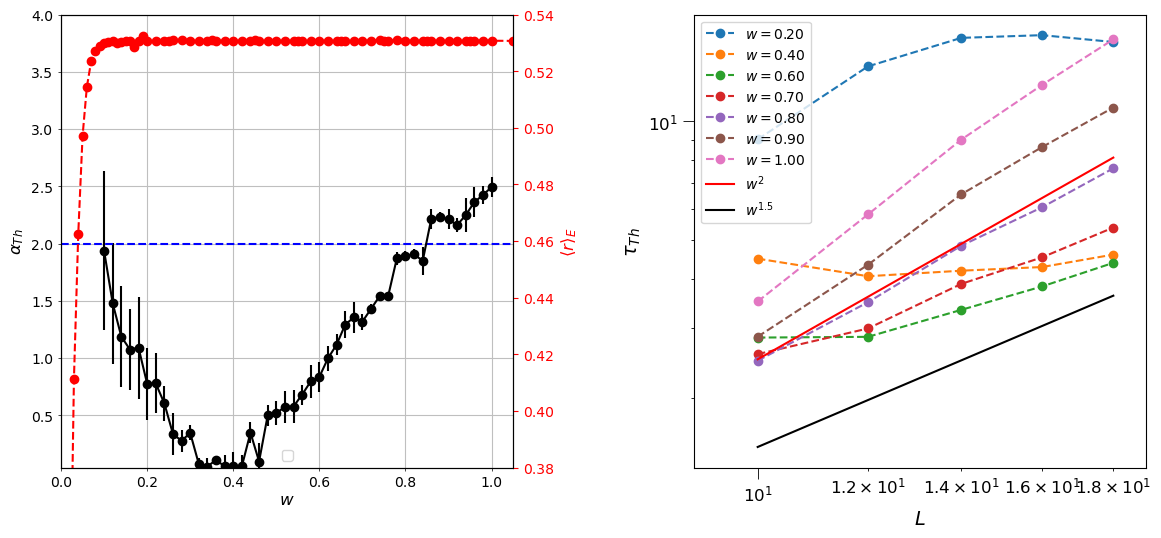

In [751]:
from multiprocessing.sharedctypes import Value


status_time, xvalues, taus, gap_ratio = get_thouless_time(par = cf.L, set_class=new_set_class)
vals_spec = hfun.get_scaling_array(user_settings)

" Find thouless data "
tau_data = []
try :
    valsup = hfun.get_scaling_array(settings=user_settings, x0=0.1, dx=0.02, xend=1.0)
    tau_data = thouless.load(settings=user_settings, vals=valsup)
except OSError:
    print("No Thouless data present") 
exponent = []
error_bars = []
for i in  range(len(tau_data[0])):
    pars, pcov = fit(f=power_law, 
                    xdata=tau_data[1][i], 
                    ydata=tau_data[2][i])
    exponent.append(pars[0])
    error_bars.append(np.sqrt(np.diag(pcov)[0]))

error_bars = np.array(error_bars)
ii = user_settings['scaling_idx']
xlab = "q/\\pi" if ii == 5 else (hfun.var_name if ii == 2 else user_settings['scaling'])



fig, (ax1, ax2) = plt.subplots( nrows=1, ncols=2, figsize=(14,6), dpi = 100)
ax1_2 = ax1.twinx()
#ax.plot(tau_data[0], exponent, marker='o')
ax1.errorbar(tau_data[0], exponent, yerr=error_bars, marker='o', color='black')

if user_settings['scaling_idx'] == 2:
    try:
        idx = list(tau_data[0]).index(cf.g)
        ax1.plot([tau_data[0][idx], tau_data[0][idx]], [0.0, exponent[idx]], color='black', linestyle='--', marker='o')
    except ValueError:
        print(r"$\Delta=0.55$" + f" not found")
ax1_2.plot(xvalues, gap_ratio, marker='o', linestyle='--', color='red')
ax1_2.set_ylim(0.38, 0.54)
ax1_2.set_ylabel(r"$\langle r\rangle_E$", color='red', fontsize=12)
ax1_2.tick_params(axis='y', color='red', labelcolor='red')

set_inset_style(axis = ax1, 
                vals = tau_data[0], 
                set_class = new_set_class,
                ylim = (0, 4),
                ylabel = "\\alpha_{Th}")
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlim(0.0, None)
ax1.axhline(y=2.0, linestyle='--', color='blue')

pars = [0.3, 0.4, 0.46, 0.55, 0.6, 0.7, 0.8, 0.9, 1.0] \
        if user_settings['scaling_idx'] == 2 else [0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0]
for i in range(len(tau_data[0])):  tau_data[0][i] = round(tau_data[0][i], 3)

for xxx in pars:
    try:
        idx = list(tau_data[0]).index(xxx)
        ax2.plot(tau_data[1][idx], tau_data[2][idx], linestyle='--', marker='o', label=hfun.key_title(x=xxx, settings=user_settings) )
    except ValueError:
        print(r"$\Delta=%.2f$"%xxx + f" not found")


hfun.set_plot_elements(axis = ax2, xlim = (9, 19), 
                            ylim = (None, 3e1), ylabel = "\\tau_{Th}", xlabel = "L", 
                            font_size=12, set_legend=True)
ax2.set_xscale('log')
ax2.set_yscale('log')
x=tau_data[1][0]
ax2.plot(x, 2.5*(x/10.)**(2), color='red', label=r"$%s^{2}$"%xlab)
ax2.plot(x, 1.5*(x/10.)**(1.5), color='black', label=r"$%s^{1.5}$"%xlab)

ax2.legend()

fig.subplots_adjust(wspace=0.4)
print(1./0.)

## SHOW FIT AND RELAX TIME PLOT

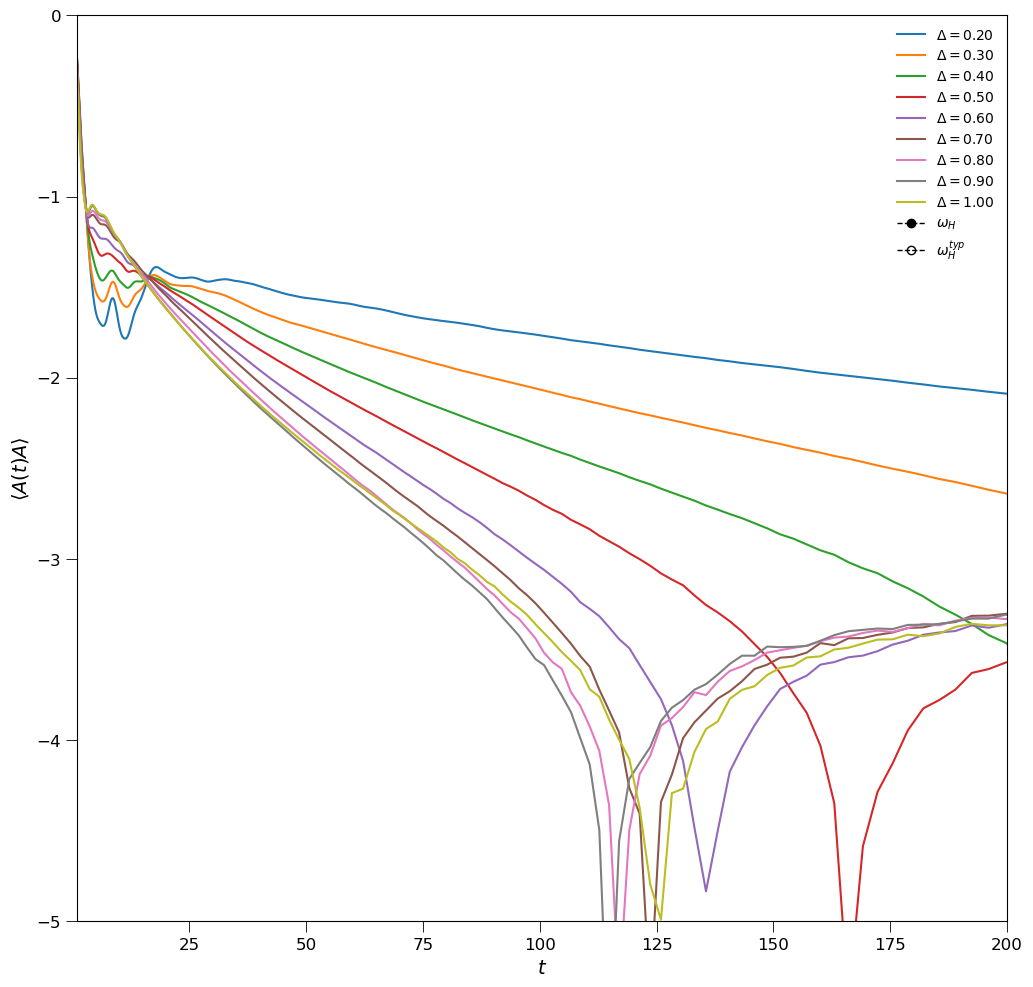

In [ ]:


fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(12,12), dpi = 100)

func = lambda y, x: y# * x**1.33

xxx = 0.02

vals = hfun.get_scaling_array(settings=user_settings, 
                                    x0=0.2, 
                                    xend=1.02, 
                                    dx=0.1)
#---------------------- TIME EVOLUTION
#spec_fun.plot_spectral(axis = axis, settings=user_settings, vals = vals,
#                        xlab="t", ylab="\\langle A(t)A\\rangle", 
#                        yscale='linear', normalise=True, 
#                        spec="time", func_x=func)


relaxt_time_fit = []
tH = []
tH_typ = []
for i in range(0, len(vals)):
    x = vals[i]
    status, xdata, ydata, wHnow, wHtypnow = spec_fun.load_spectral(dir=time_dir, 
                                                                    settings=user_settings, 
                                                                    parameter=x,
                                                                    spec="time",
                                                                    normalise=True
                                                                    )
    if status:
        xfull = xdata
        cut = 50
        if x <= 0.2: cut = 80
        #|xdata = np.array([xdata[i] for i in range(0,len(xdata)) if (xdata[i] < 5000 and xdata[i] > cut)])
        #|ydata = np.array([ydata[i] for i in range(0,len(ydata)) if (xfull[i] < 5000 and xfull[i] > cut)])
        
        ydata = np.log10(np.abs(ydata))
        idx_zero = np.argmin((ydata))
        ydata = ydata[:idx_zero - 5]
        xdata = xdata[:idx_zero - 5]
        #
        axis.plot(xdata, ydata, label=hfun.key_title(x, user_settings))

        #idx = np.where(ydata == np.amin(ydata))
        #print(idx)
        xfull = xdata
        #xdata = np.array([xdata[i] for i in range(0,len(xdata)) if (ydata[i] < -1.2)])
        #ydata = np.array([ydata[i] for i in range(0,len(ydata)) if (ydata[i] < -1.2)])
        #print(pars2
        tH.append(wHnow)
        tH_typ.append(wHtypnow)
        pars, sth = fit(f=lin_fit, 
                            xdata=xdata, 
                            ydata=ydata)
        
        relaxt_time_fit.append(pars[0])
        #axis.plot(xdata, lin_fit(xdata, *pars), linestyle='--', color='black')
    else:
        tH.append(nan)
        tH_typ.append(nan)
        relaxt_time_fit.append(nan)

#
hfun.set_plot_elements(axis = axis, xlim = (None, None), 
                                    ylim = (None, None), ylabel = "\\langle A(t)A\\rangle", xlabel = "t", settings=settings, font_size=12, set_legend=True)
  
axis.set_xscale('linear')
axis.set_yscale('linear')
axis.set_xlim(1,2e2)
axis.set_ylim(-5,0)
add_legend(axis=axis)
#relaxt_time_fit = 1.0 / np.array(relaxt_time_fit)
tH = np.array(tH)
tH_typ = np.array(tH_typ)

No data


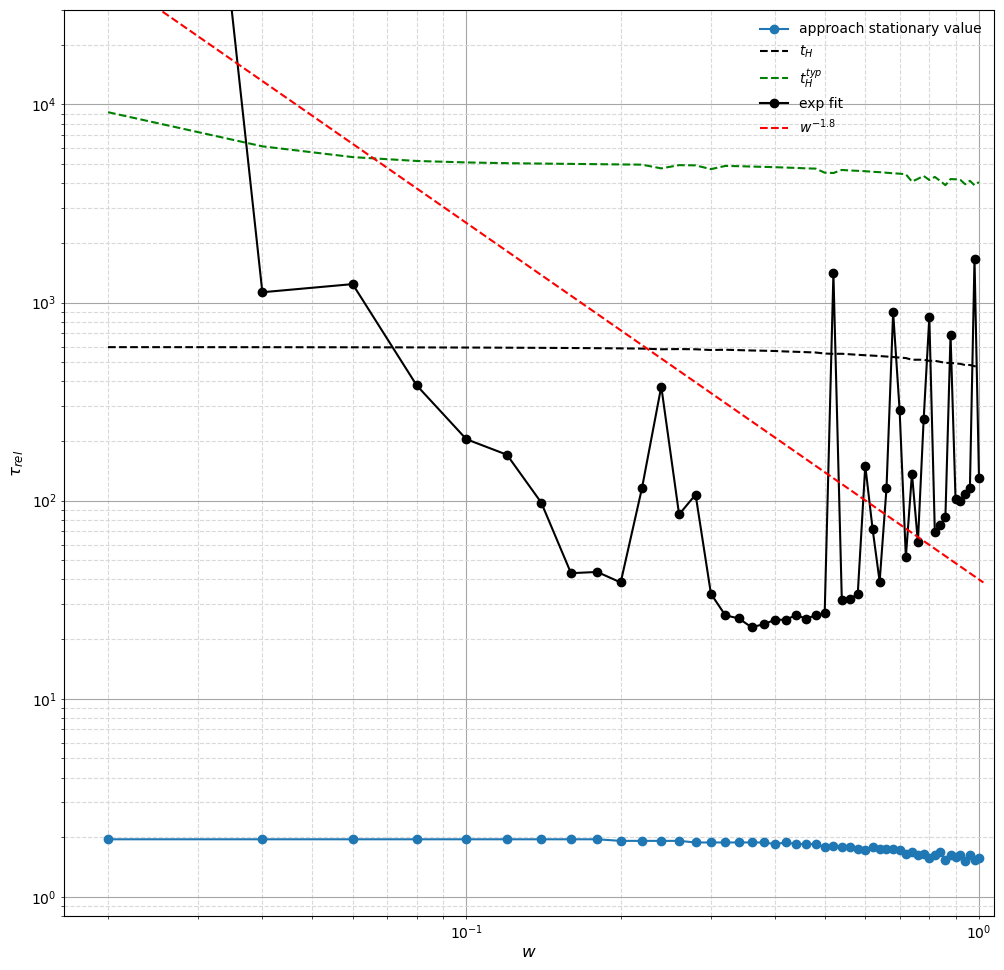

In [ ]:

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(12,12), dpi = 100)

xlab = "q/\\pi" if user_settings['scaling_idx'] == 5 else user_settings['scaling']

xrescale = lambda x: x
axis.plot(xrescale(trueQ), relax_time, marker='o', label = 'approach stationary value')

axis.plot(xrescale(vals), tH, linestyle='--', color = 'black', label = r"$t_H$")
axis.plot(xrescale(vals), tH_typ, linestyle='--', color = 'green', label = r"$t_H^{typ}$")
axis.plot(xrescale(vals), relaxt_time_fit, marker='o', color = 'black', label = 'exp fit')

axis.plot(xrescale(trueQ), 4e1/trueQ**1.8, linestyle='--', color='red', label=r"$w^{-1.8}$")

if status and user_settings['scaling_idx'] == 5: 
    axis.axhline(y=taus[0], ls='--', color='black')
    axis.annotate("$\it{Thouless}\ \it{Time}$", xy=(0.3,1.5e3), color='black', size=12)
else: 
    if status == False or cf.model == 2: print('No data')
    else: axis.plot(vals, taus, linestyle='--', color='black', label=r"$\tau_{Th}$")

hfun.set_plot_elements(axis = axis, xlim = (0.95*min(xrescale(trueQ)), 1.05*max(xrescale(trueQ))), 
                                    ylim = (8e-1, 3e4),ylabel = "\\tau_{rel}", xlabel = xlab, settings=getattr(new_set_class, 'settings'), font_size=10, set_legend=True)
  
axis.set_yscale('log')
axis.set_xscale('log')
axis.tick_params(axis='both', which='both',length=2)
axis.grid(b=True, which='major', color='0.65', linestyle='-')
axis.grid(b=True, which='minor', color='0.85', linestyle='--')


## COMPARE FUNCTIONS

### 4x panel

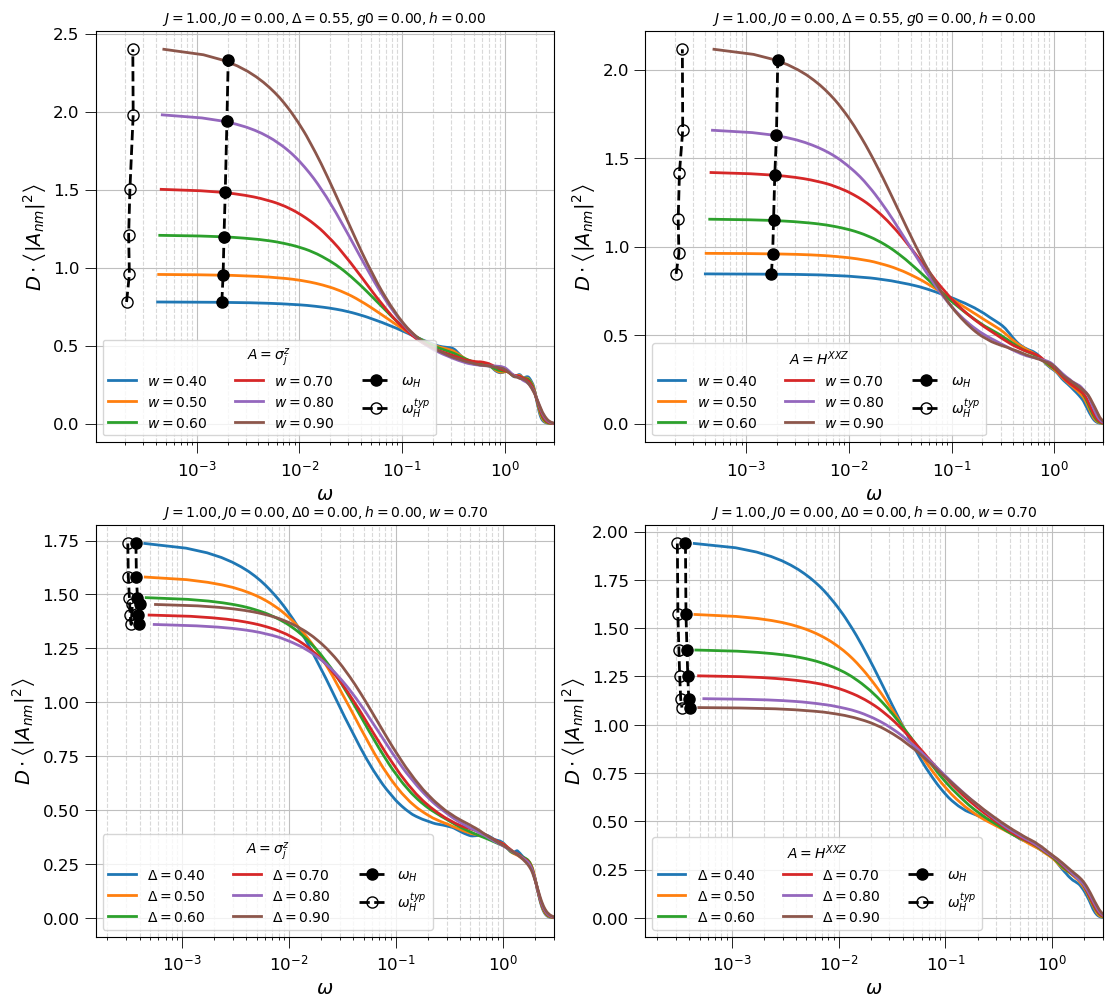

In [ ]:
import scipy.integrate as integrate
x0 = 0.4
xend = 1.0
dx = 0.1
vals = hfun.get_scaling_array(user_settings, x0, xend, dx)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(13,12), dpi = 100)

cut_off_large_omega = 0

def temporary_plot_spec(axis, operatorr, settings):
    wH = [];    LTA = []
    wH_typ = [];    val_at_typ = [];
    omegas = np.logspace(-5, 0, 1000)
    for x in vals:                    
        status, xdata, ydata, wHnow, wHtypnow = spec_fun.load_spectral(dir=spec_dir, 
                                                        settings=settings, 
                                                        parameter=x,
                                                        spec="spec",
                                                        func_x=lambda x, a: x,
                                                        operator = operatorr,
                                                        site = settings['site']
                                                        )
        if cut_off_large_omega:
            ydata = np.array([ydata[i] for i in range(0,len(ydata)) if (xdata[i] < 3.0)])
            xdata = np.array([xdata[i] for i in range(0,len(xdata)) if (xdata[i] < 3.0)])
        ydata = ydata * (2**x / x if settings['scaling_idx'] == 0 else 2**cf.L / cf.L) # rescale by D                                                    
        
        p = axis.plot(xdata, ydata,label=hfun.key_title(x, settings), linewidth=2, markersize=6)
        "mean";     wH.append(wHnow);           idx = min(range(len(xdata)), key=lambda i: abs(xdata[i] - wHnow));     LTA.append(ydata[idx])
        "typical";  wH_typ.append(wHtypnow);    idx = min(range(len(xdata)), key=lambda i: abs(xdata[i] - wHtypnow));  val_at_typ.append(ydata[idx])
        
        "lorentzian only with cut off"
        if cut_off_large_omega:
            new_set_class = copy.deepcopy(cf.plot_settings)
            new_set_class.set_vs(settings['scaling'])
            new_set_class.set_scaling('L')
            tau_data = []
            status = False
            try :
                tau_data = thouless.load(getattr(new_set_class, 'settings'))
                status = True
            except OSError:
                print("No Thouless data present")
            x_for_tau = []
            taus = []
            if status:    
                idx = list(tau_data[0]).index(cf.L)
                x_for_tau = tau_data[1][idx]
                taus = tau_data[2][idx]
            idx = min(range(len(x_for_tau)), key=lambda i: abs(x_for_tau[i] - x))
            factor = 1
            tau = factor * taus[idx]
            norm = integrate.simpson(y=ydata, x=xdata)
            axis.plot(omegas, ydata[0] / (1 + (omegas * tau)**2 ), color=p[0].get_color(), linestyle='--')
    
    #axis.plot(omegas, 0.4 / (omegas)**0.5, linestyle='--', color='red', label=r"$\omega^{-0.5}$") 
    #axis.plot(omegas, 0.1 / (omegas)**0.75, linestyle='--', color='black', label=r"$\omega^{-0.75}$")        
    hfun.set_plot_elements(axis = axis, ylabel = "D\\cdot\\left\\langle|A_{nm}|^2\\right\\rangle", xlabel = "\\omega", settings=settings, font_size=12, set_legend=False, xlim=(None, None), ylim=(None, None))
    axis.set_xscale('log')
    axis.set_yscale('linear')
    x_min = 0.5 * np.min(wH_typ)
    if cut_off_large_omega: axis.set_xlim(x_min, 3e0)
    else: axis.set_xlim(x_min, 3e0)
    axis.grid(b=True, which='major', color='0.75', linestyle='-')
    axis.grid(b=True, which='minor', color='0.85', linestyle='--')
    #add_legend(axis=axis)
    
    axis.plot(wH, LTA, linestyle='--', marker='o', color='black', linewidth=2, markersize=8, label=r"$\omega_H$")
    axis.plot(wH_typ, val_at_typ, linestyle='--', marker='o', color='black', markerfacecolor='None', linewidth=2, markersize=8, label=r"$\omega_H^{typ}$")
    try:
        idx = (cf.operator_formuals[operatorr][2:]).index("=")
        leg = axis.legend(title=r"$A=$"+cf.operator_formuals[operatorr][0:idx] + "$", loc='lower left', ncol=3)
    except ValueError:
        leg = axis.legend(title=r"$A=$"+cf.operator_formuals[operatorr], loc='lower left', ncol=3)

    title = ""
    if (settings['vs_idx'] == 3 or settings['scaling_idx'] == 3) and cf.J0 == 0 and cf.g0 == 0 and cf.h != 0:
        title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'], 'w') + ',w=0.5h'
    else :
        title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'])
    if settings['vs_idx'] != 2 :
        try : 
            title = list(title);    title[title.index('g')] = hfun.var_name;   title = "".join(title) # g
        except ValueError:
                print("not found")
    axis.title.set_text(r"$%s$"%title[1:])
    axis.title.set_fontsize(10)

cf.set_params(_g=0.55)
temporary_plot_spec(axis=ax1, operatorr=0, settings=user_settings)
temporary_plot_spec(axis=ax2, operatorr=2, settings=user_settings)

cf.set_params(_w=0.7)
new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_scaling("g")
settings = getattr(new_set_class, 'settings')
temporary_plot_spec(axis=ax3, operatorr=0, settings=settings)
temporary_plot_spec(axis=ax4, operatorr=2, settings=settings)

### 1-panel single disorder

In [ ]:
w = 1.0
L = 14

status2, xdata2, ydata2, wHnow, wHtypnow = spec_fun.load_spectral(dir=spec_dir, 
                                                                    settings=user_settings, 
                                                                    parameter=x,
                                                                    spec="spec",
                                                                    normalise=True,
                                                                    operator=0
                                                                    )